In [2]:
import pykep as pk
import numpy as np
import json
import pickle as pkl
import requests
import pygmo as pg

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
%matplotlib notebook

In [3]:
import cascade as csc
from copy import deepcopy
from tqdm.notebook import tqdm
import heyoka as hy

# We obtain atmospheric data from the nrlmsise00 model
An account is needed at https://amentum.com.au/atmosphere and an API-Key allowing a limited amounts of queries

In [4]:
# This will contain the density in kg/m3
density = []
# This is the grid on the altitude
altitude = np.linspace(78, 1000, 100)

... uncomment and run this cell to retreive the data again, else use the pickled file

In [5]:
#url = "https://atmosphere.amentum.io/nrlmsise00"

#headers = {"API-Key" : "Pmd5s5e36Ny0zpPGhxvDWRtgrmB2rR6K"}
#for alt in altitude:
#    params = {
#        'year' : 2021,
#        'month' : 2,
#        'day' : 1,
#        'geodetic_latitude' : 0,
#        'geodetic_longitude' : 42,
#        'altitude' : alt, # km
#        'utc' : 2, # hours
#    }
#    # handle exceptions
#    response = requests.get(url, params=params, headers=headers)
#    json_payload = response.json()
#    density.append(json_payload['total_mass_density']['value'])

#with open('data/atmosphere.pk', 'wb') as file:
#    pkl.dump((altitude, density), file)

In [6]:
with open("data/atmosphere.pk", "rb") as file:
    altitude, density = pkl.load(file)

# We try and fit the data with some predefined shape
It is important that the limit for h that goes to infinity of the density goes to zero. The chosen shape must guarantee this property. We here use:

$$
\rho(h) = \sum_i\alpha_i\exp(-\beta_i(h-\gamma_i))
$$

In [7]:
class my_udp:
    def __init__(self, X, Y, n=4):
        self.X = X
        self.Y = Y
        self.n = n
    def fitness(self,x):
        p1 = x[:self.n]
        p2 = x[self.n:2*self.n]
        p3 = x[2*self.n:]
        Y_pred = self._fitting_function(self.X,p1,p2, p3)
        return [np.mean(np.abs(np.log10(self.Y)-np.log10(Y_pred)))]
    def _fitting_function(self, x, p1,p2, p3):
        retval = 0.
        for alpha,beta, gamma in zip(p1,p2, p3):
            retval += alpha*np.exp(-(x-gamma)*beta)
        return retval
    def get_bounds(self):
        lb = [0]*self.n*3
        ub = [1.]*self.n*3
        ub[self.n*2:] = [1000]*self.n
        return (lb, ub)

In [8]:
udp = my_udp(altitude, density, n=4)
prob = pg.problem(udp)

In [9]:
uda = pg.sade(50, memory=True)
algo = pg.algorithm(uda)

In [12]:
pop  =pg.population(prob, 20)

/tmp/ipykernel_95708/3726744109.py:15: RuntimeWarning: overflow encountered in exp
  retval += alpha*np.exp(-(x-gamma)*beta)


In [13]:
for i in range(500):
    pop = algo.evolve(pop)
    print(pop.champion_f[0])

/tmp/ipykernel_95708/3726744109.py:15: RuntimeWarning: overflow encountered in exp
  retval += alpha*np.exp(-(x-gamma)*beta)
/tmp/ipykernel_95708/3726744109.py:11: RuntimeWarning: divide by zero encountered in log10
  return [np.mean(np.abs(np.log10(self.Y)-np.log10(Y_pred)))]


4.080522337279292
3.1474947349095923
2.655456179820204
2.305157166639098
1.736422725023861
1.339720095317044
1.116307374753063
0.9188851466005192
0.8005061854603974
0.7377380594092879
0.6804637039962778
0.6050299332372546
0.5833137613503093
0.5669468624424969
0.5445710984710856
0.5326702946987947
0.5125883470771814
0.4923867946635031
0.46248013764838874
0.45588148452938726
0.4411259972720247
0.44112597613406007
0.42909912778247433
0.42486521284771006
0.4224073409311714
0.42021742858567507
0.4196622798824013
0.4184053181634411
0.418309166218074
0.41787776706958746
0.4152195800321312
0.41503713709392265
0.413844222985639
0.4133179617997132
0.4128930127309569
0.4111936029933696
0.41114718245420834
0.409062536077424
0.409062536077424
0.408563595321941
0.40856118290317006
0.40853523596729796
0.4083156161018745
0.4082988035816513
0.40827902773393654
0.40720416762202155
0.4068189101049946
0.40590321708310334
0.4009987792476468
0.39911818797045
0.3958577194380598
0.3958576890204636
0.395624040

0.012297968017584857
0.012297968017584857
0.012297968017584857
0.012297968017584857
0.012297968017584857
0.012297968017584857
0.012297968017584857
0.012297968017584857
0.012297968017584857
0.012297968017584857
0.012297968017584857
0.012297968017584857
0.012297968017584857
0.012297968017584857
0.012297968017584857
0.012297968017584857
0.012297968017584857
0.012297968017584857
0.012297968017584857
0.012297968017584857
0.012297968017584857
0.012297968017584857
0.012297968016856248
0.012297968016856248
0.012297968016856248
0.012297968016856248
0.012297968016856248
0.012297968016856248
0.012297968016856248
0.012297968016856248
0.012297968016856248
0.012297968016856248


# We plot the data and the fit

In [15]:
def compute_density(h_in_km, best_x):
    """
    returns the atmosheric density in kg.m^3
    """
    p1 = np.array(best_x[:4])
    p2 = np.array(best_x[4:8])
    p3 = np.array(best_x[8:])
    retval = 0.
    for alpha,beta, gamma in zip(p1,p2, p3):
        retval += alpha*np.exp(-(h_in_km-gamma)*beta)
    return retval

<IPython.core.display.Javascript object>


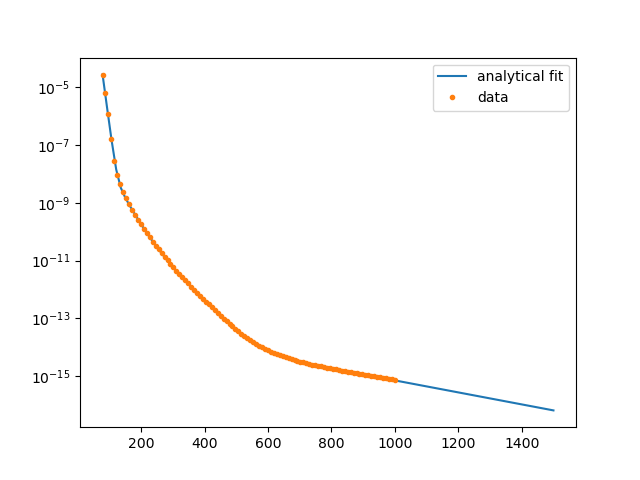

In [17]:
plt.figure()
altitudes = np.linspace(78, 1500, 100)
plt.semilogy(altitudes, compute_density(altitudes, pop.champion_x), label ='analytical fit')
plt.semilogy(altitude, density, '.', label='data')
plt.legend()

In [18]:
with open("data/best_fit_density.pk", "wb") as file:
    pkl.dump(pop.champion_x, file)